In [ ]:
%pip install minio

In [ ]:
import os

# MinIO server information
minio_endpoint = os.getenv('WS_S3_ENDPOINT')  # Your MinIO server URL
access_key = os.getenv('AWS_ACCESS_KEY_ID')
secret_key = os.getenv('AWS_SECRET_ACCESS_KEY')
bucket_name = os.getenv('AWS_S3_BUCKET')
object_key = 'gdotdata.zip'  # The file you want to pull
download_path = 'trafficCounter/model/gdotdata.zip'  # Where to save the file

dataset_dir = "datasets"


# Pull model data

In [ ]:
from minio import Minio
import urllib3
from minio.error import S3Error
from urllib3 import PoolManager
import ssl
import os



# Create directory if it doesn't exist
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# # Set the current working directory
# os.chdir('datasets')

# Suppress SSL warnings
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Create a custom HTTP client to allow self-signed certificates
http_client = PoolManager(
    cert_reqs='CERT_NONE',  # Do not verify SSL certificates
    ssl_context=ssl.create_default_context(ssl.Purpose.CLIENT_AUTH)
)

# Initialize the MinIO client with the custom HTTP client
minio_client = Minio(
    "minio-s3-trafficcounter.apps.ocp4.davenet.local",  # Replace with your MinIO server endpoint and port
    access_key="minioadmin",  # Replace with your access key
    secret_key="minioadmin",  # Replace with your secret key
    secure=True,  # Still using https, but with self-signed certs allowed
    http_client=http_client  # Pass the custom HTTP client
)

# Specify the bucket name and object name
bucket_name = "gdot"
object_name = "gdotdata.zip"
file_path = dataset_dir + "/gdotdata.zip"  # Local path where the file will be saved

try:
    # Download the object from the bucket
    minio_client.fget_object(bucket_name, object_name, file_path)
    print(f"Object '{object_name}' downloaded successfully to '{file_path}'")
except S3Error as e:
    print(f"Error occurred: {e}")


# Unzip data

In [ ]:
!unzip datasets/gdotdata.zip -d datasets

# Distribute training data

In [ ]:
import os
import random
import shutil


# # Set the current working directory
# os.chdir('datasets')

# # Print the current working directory to confirm
# print("Current Working Directory:", os.getcwd())

# path = os.getcwd()
# print("Current Path is: " + str(path))

# Set the paths for the original image and label directories
image_dir = dataset_dir + "/images"
label_dir = dataset_dir + "/labels"

# Set the path for the training directory
training_dir = dataset_dir + "/training"

# Set the desired proportions for train, test, and valid sets
train_split = 0.7
test_split = 0.15
valid_split = 0.15

def count_files(directory):
    file_count = 0
    # Iterate over all files in the directory
    for _, _, files in os.walk(directory):
        file_count += len(files)
    return file_count

# Create the training directory
os.makedirs(training_dir, exist_ok=True)

# Create the train, test, and valid directories within the training directory
train_dir = os.path.join(training_dir, "train")
test_dir = os.path.join(training_dir, "test")
valid_dir = os.path.join(training_dir, "valid")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)

# Create image and label directories within train, test, and valid directories
train_image_dir = os.path.join(train_dir, "images")
train_label_dir = os.path.join(train_dir, "labels")
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(train_label_dir, exist_ok=True)

test_image_dir = os.path.join(test_dir, "images")
test_label_dir = os.path.join(test_dir, "labels")
os.makedirs(test_image_dir, exist_ok=True)
os.makedirs(test_label_dir, exist_ok=True)

valid_image_dir = os.path.join(valid_dir, "images")
valid_label_dir = os.path.join(valid_dir, "labels")
os.makedirs(valid_image_dir, exist_ok=True)
os.makedirs(valid_label_dir, exist_ok=True)

# Retrieve the list of image filenames
image_filenames = os.listdir(image_dir)

# Shuffle the image filenames
random.shuffle(image_filenames)

# Calculate the number of images for each set
total_images = len(image_filenames)
train_count = int(total_images * train_split)
test_count = int(total_images * test_split)
valid_count = total_images - train_count - test_count

# Copy images and labels to the train directory
for filename in image_filenames[:train_count]:
    name, extension = os.path.splitext(filename)

    src_image_path = os.path.join(image_dir, filename)
    dest_image_path = os.path.join(train_image_dir, filename)
    shutil.copy(src_image_path, dest_image_path)

    label_filename, _ = os.path.splitext(filename)

    # Use the original filename without extension
    label_filename += ".txt"  # Append ".txt" extension
    src_label_path = os.path.join(label_dir, label_filename)
    dest_label_path = os.path.join(train_label_dir, label_filename)
    shutil.copy(src_label_path, dest_label_path)

# Copy images and labels to the test directory
for filename in image_filenames[train_count : train_count + test_count]:
    name, extension = os.path.splitext(filename)

    src_image_path = os.path.join(image_dir, filename)
    dest_image_path = os.path.join(test_image_dir, filename)
    shutil.copy(src_image_path, dest_image_path)

    label_filename, _ = os.path.splitext(filename)

    # Use the original filename without extension
    label_filename += ".txt"  # Append ".txt" extension
    src_label_path = os.path.join(label_dir, label_filename)
    dest_label_path = os.path.join(test_label_dir, label_filename)
    shutil.copy(src_label_path, dest_label_path)

# Copy images and labels to the valid directory
for filename in image_filenames[train_count + test_count :]:
    name, extension = os.path.splitext(filename)

    src_image_path = os.path.join(image_dir, filename)
    dest_image_path = os.path.join(valid_image_dir, filename)
    shutil.copy(src_image_path, dest_image_path)

    label_filename, _ = os.path.splitext(filename)

    # Use the original filename without extension
    label_filename += ".txt"  # Append ".txt" extension
    src_label_path = os.path.join(label_dir, label_filename)
    dest_label_path = os.path.join(valid_label_dir, label_filename)
    shutil.copy(src_label_path, dest_label_path)

print("Dataset files distributed to folders: test, train, and valid")

directory_path = dataset_dir + "/training/test/images"
num_test = count_files(directory_path)
directory_path = dataset_dir + "/training/train/images"
num_train = count_files(directory_path)
directory_path = dataset_dir + "/training/valid/images"
num_valid = count_files(directory_path)

num_total = num_test + num_train + num_valid

print("File count - Test:       [" + format(num_test/num_total, ".0%") + "] " + str(num_test))
print("File count - Train:      [" + format(num_train/num_total, ".0%") + "] " + str(num_train))
print("File count - Validation: [" + format(num_valid/num_total, ".0%") + "] " + str(num_valid))

# Create the class file

In [ ]:
import yaml

# Read lines from the text file
with open(dataset_dir + '/classes.txt', 'r') as file:
    lines = file.read().splitlines()

# Prepare the data for the YAML file
yaml_data = {
    'path': 'training',
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'nc': len(lines),
    'names': lines
}

# Write to a YAML file
with open(dataset_dir + '/gdot.yaml', 'w') as yaml_file:
    yaml.dump(yaml_data, yaml_file, default_flow_style=False, sort_keys=False)

print("YAML file 'gdot.yaml' created successfully.")



# Train the model

In [ ]:
!yolo train source=datasets/training model=yolov8n.pt epochs=100 batch=16 data=datasets/gdot.yaml project=runs

# Show the results

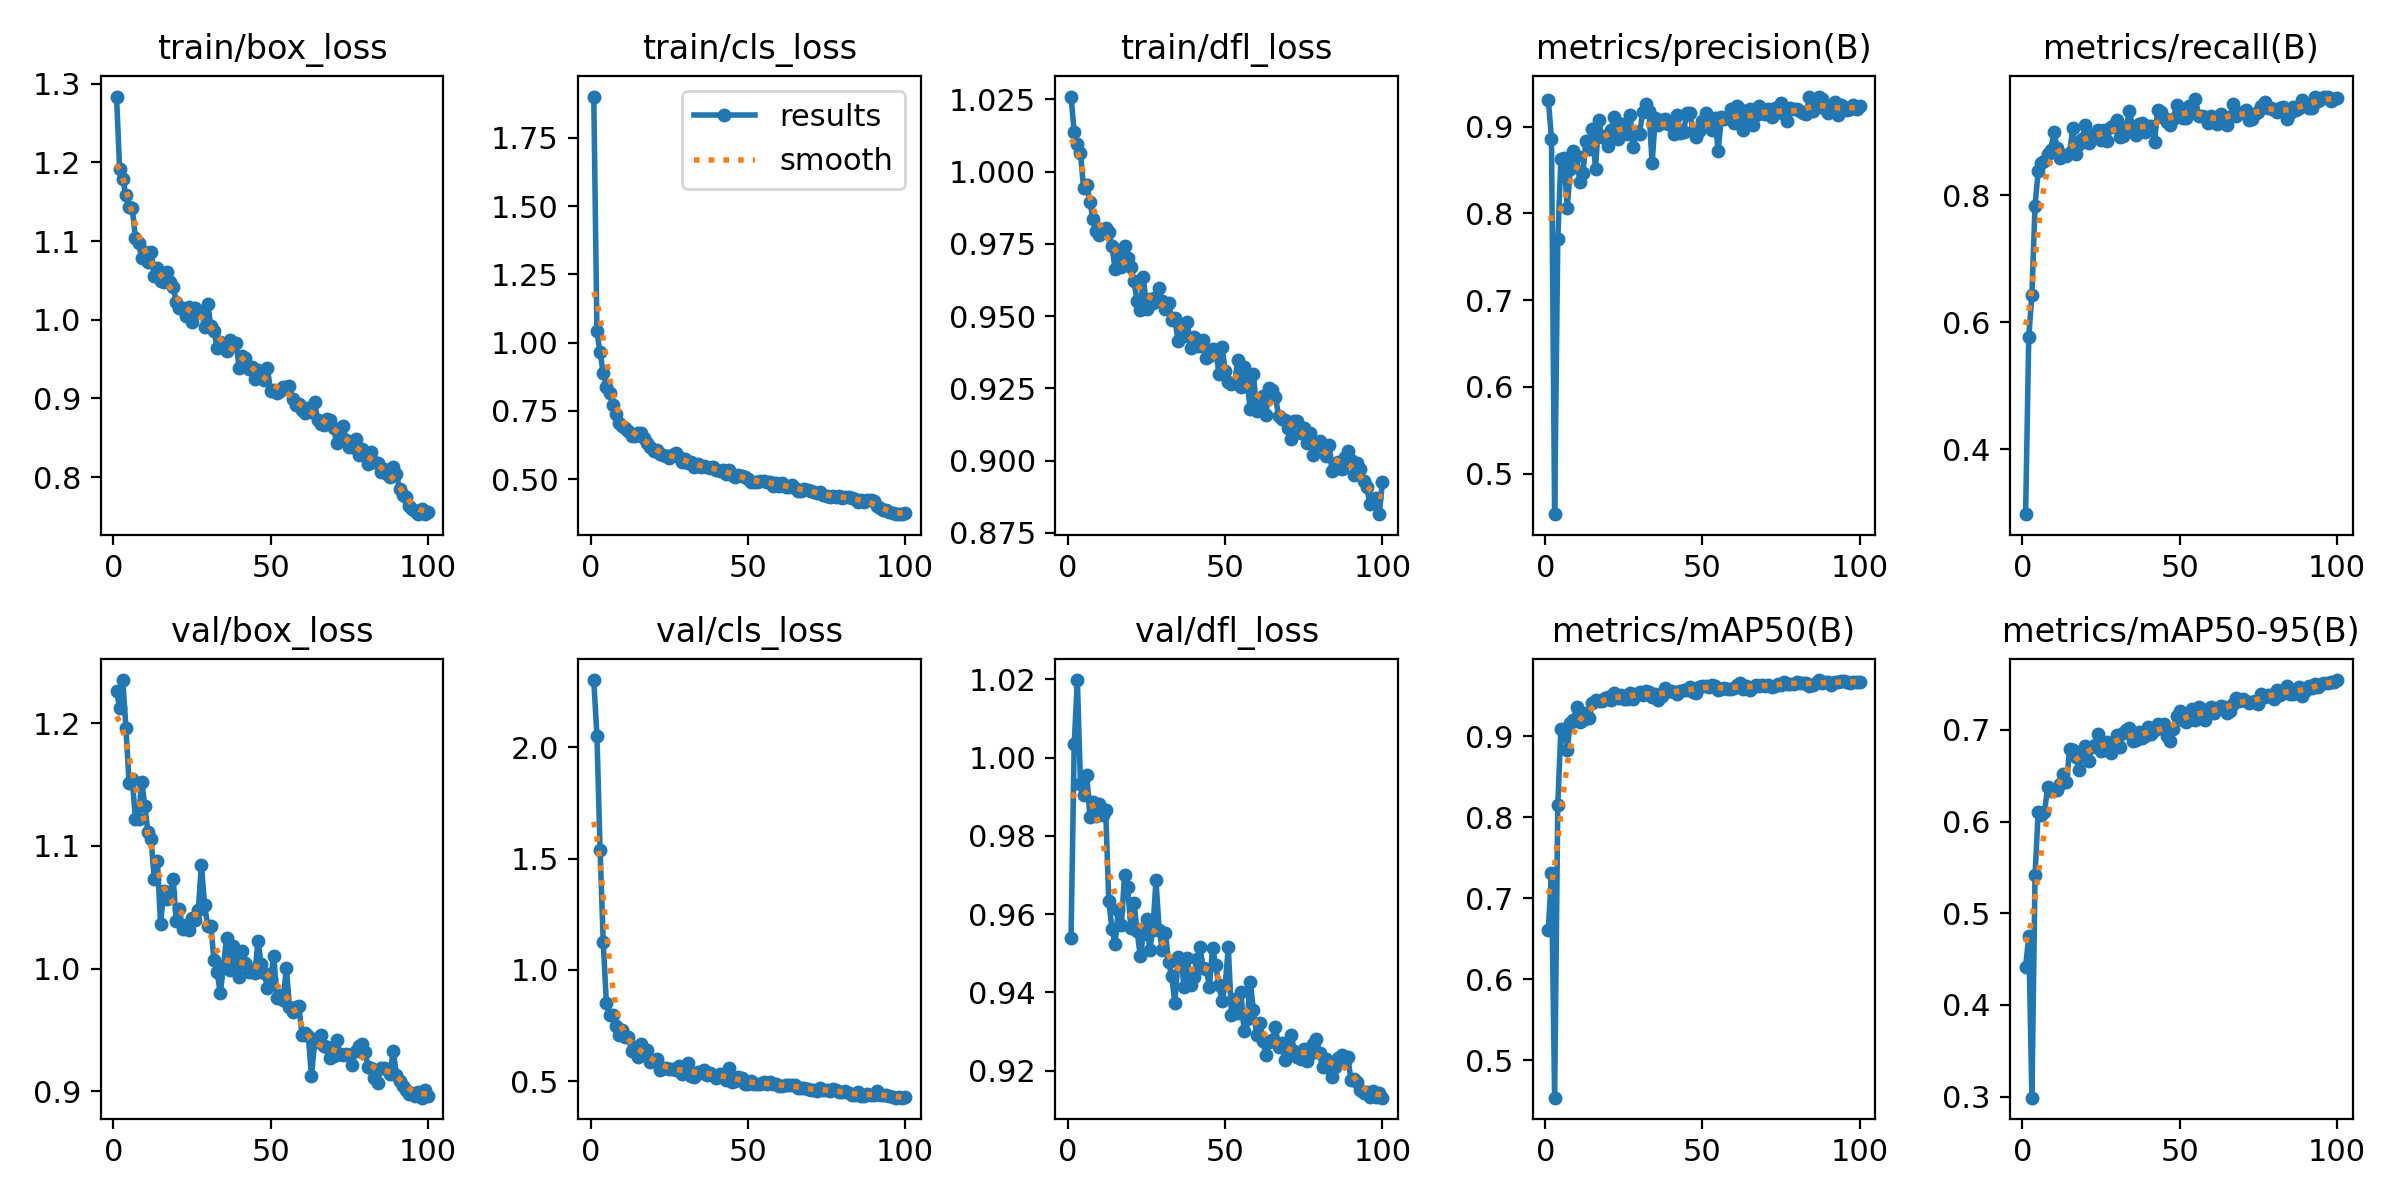

In [18]:
import os
from PIL import Image
from IPython.display import display

# Open an image file
img = Image.open('runs/train/results.png')

# Display the image in the notebook
display(img)


# Export the new model

In [ ]:
!yolo export model="runs/train/weights/best.pt" format=onnx imgsz=224,128

# Copy model to bucket

In [ ]:
from minio import Minio
from minio.error import S3Error
import urllib3

# Suppress SSL warnings
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Create a custom HTTP client to allow self-signed certificates
http_client = PoolManager(
    cert_reqs='CERT_NONE',  # Do not verify SSL certificates
    ssl_context=ssl.create_default_context(ssl.Purpose.CLIENT_AUTH)
)

# Initialize the MinIO client with the custom HTTP client
minio_client = Minio(
    "minio-s3-trafficcounter.apps.ocp4.davenet.local",  # Replace with your MinIO server endpoint and port
    access_key="minioadmin",  # Replace with your access key
    secret_key="minioadmin",  # Replace with your secret key
    secure=True,  # Still using https, but with self-signed certs allowed
    http_client=http_client  # Pass the custom HTTP client
)

# Set file and bucket details
file_path = "runs/train/weights/best.onnx"  # Local file path
bucket_name = "gdot"  # MinIO bucket name
object_name = "best.onnx"  # Name to save in the bucket

try:
    # Upload the file to the MinIO bucket
    minio_client.fput_object(
        bucket_name, object_name, file_path
    )
    print(f"File '{file_path}' uploaded to bucket '{bucket_name}' as '{object_name}'.")

except S3Error as e:
    print(f"Error occurred: {e}")
